# Flocking in prey as an emergent property
It has long been established that flocking can help increase protection from predators. Multiple theories have been put forward such as the selfish herd theory etc. These theories tend to include predefined assumptions such as predator confusion or a minimisation of the DoD to make flocking more attractive. Here, we attempt to observe flocking as a purely emerging behaviour without providing explicit benefits.

The code is based on https://github.com/pytorch/rl/blob/main/tutorials/sphinx-tutorials/multiagent_competitive_ddpg.py

## Imports

In [1]:
import copy
import tempfile

import torch

from vmas import render_interactively
from vmas.simulator.core import Agent, Landmark, Line, Sphere, World
from vmas.simulator.scenario import BaseScenario
from vmas.simulator.utils import Color, ScenarioUtils

from matplotlib import pyplot as plt
from tensordict import TensorDictBase

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from tqdm import tqdm

/home/lilly/dev/marl-predator-prey/marl-predator-prey/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## General
Setting up of constants such as the seed and hyperparameters.

In [2]:
# Seed
seed = 42
torch.manual_seed(seed)

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

# Sampling
frames_per_batch = 10_000 # Number of team frames collected per sampling iteration
n_iters = 100  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# We will stop training the predators after this many iterations,
# should be 0 <= iteration_when_stop_training_predators <= n_iters
# iteration_when_stop_training_predators = n_iters // 2
iteration_when_stop_training_predators = 0

# Replay buffer
memory_size = 1_000_000  # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 100  # Number of optimization steps per training iteration
train_batch_size = 128  # Number of frames trained in each optimiser step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# DDPG
gamma = 0.99  # Discount factor
polyak_tau = 0.005  # Tau for the soft-update of the target network


## Scenario
Based on https://github.com/proroklab/VectorizedMultiAgentSimulator/blob/main/vmas/scenarios/mpe/simple_tag.py

In [3]:
class PredationScenario(BaseScenario):
    def make_world(self, batch_dim: int, device: torch.device, **kwargs):
        num_good_agents = kwargs.pop("num_good_agents", 1)
        num_adversaries = kwargs.pop("num_adversaries", 3)
        num_landmarks = kwargs.pop("num_landmarks", 2)
        self.shape_agent_rew = kwargs.pop("shape_agent_rew", False)
        self.shape_adversary_rew = kwargs.pop("shape_adversary_rew", False)
        self.agents_share_rew = kwargs.pop("agents_share_rew", False)
        self.adversaries_share_rew = kwargs.pop("adversaries_share_rew", True)
        self.observe_same_team = kwargs.pop("observe_same_team", True)
        self.observe_pos = kwargs.pop("observe_pos", True)
        self.observe_vel = kwargs.pop("observe_vel", True)
        self.bound = kwargs.pop("bound", 1.0)
        self.respawn_at_catch = kwargs.pop("respawn_at_catch", False)
        ScenarioUtils.check_kwargs_consumed(kwargs)

        self.visualize_semidims = False

        world = World(
            batch_dim=batch_dim,
            device=device,
            x_semidim=self.bound,
            y_semidim=self.bound,
            substeps=10,
            collision_force=500,
        )
        # set any world properties first
        num_agents = num_adversaries + num_good_agents
        self.adversary_radius = 0.075

        # Add agents
        for i in range(num_agents):
            adversary = True if i < num_adversaries else False
            name = f"adversary_{i}" if adversary else f"agent_{i - num_adversaries}"
            agent = Agent(
                name=name,
                collide=True,
                shape=Sphere(radius=self.adversary_radius if adversary else 0.05),
                u_multiplier=3.0 if adversary else 4.0,
                max_speed=1.0 if adversary else 1.3,
                color=Color.RED if adversary else Color.GREEN,
                adversary=adversary,
            )
            world.add_agent(agent)
        # Add landmarks
        for i in range(num_landmarks):
            landmark = Landmark(
                name=f"landmark {i}",
                collide=True,
                shape=Sphere(radius=0.2),
                color=Color.BLACK,
            )
            world.add_landmark(landmark)

        return world

    def reset_world_at(self, env_index: int = None):
        for agent in self.world.agents:
            agent.set_pos(
                torch.zeros(
                    (
                        (1, self.world.dim_p)
                        if env_index is not None
                        else (self.world.batch_dim, self.world.dim_p)
                    ),
                    device=self.world.device,
                    dtype=torch.float32,
                ).uniform_(
                    -self.bound,
                    self.bound,
                ),
                batch_index=env_index,
            )

        for landmark in self.world.landmarks:
            landmark.set_pos(
                torch.zeros(
                    (
                        (1, self.world.dim_p)
                        if env_index is not None
                        else (self.world.batch_dim, self.world.dim_p)
                    ),
                    device=self.world.device,
                    dtype=torch.float32,
                ).uniform_(
                    -(self.bound - 0.1),
                    self.bound - 0.1,
                ),
                batch_index=env_index,
            )

    def is_collision(self, agent1: Agent, agent2: Agent):
        delta_pos = agent1.state.pos - agent2.state.pos
        dist = torch.linalg.vector_norm(delta_pos, dim=-1)
        dist_min = agent1.shape.radius + agent2.shape.radius
        return dist < dist_min

    # return all agents that are not adversaries
    def good_agents(self):
        return [agent for agent in self.world.agents if not agent.adversary]

    # return all adversarial agents
    def adversaries(self):
        return [agent for agent in self.world.agents if agent.adversary]

    def reward(self, agent: Agent):
        is_first = agent == self.world.agents[0]

        if is_first:
            for a in self.world.agents:
                a.rew = (
                    self.adversary_reward(a) if a.adversary else self.agent_reward(a)
                )
            self.agents_rew = torch.stack(
                [a.rew for a in self.good_agents()], dim=-1
            ).sum(-1)
            self.adverary_rew = torch.stack(
                [a.rew for a in self.adversaries()], dim=-1
            ).sum(-1)
            if self.respawn_at_catch:
                for a in self.good_agents():
                    for adv in self.adversaries():
                        coll = self.is_collision(a, adv)
                        a.state.pos[coll] = torch.zeros(
                            (self.world.batch_dim, self.world.dim_p),
                            device=self.world.device,
                            dtype=torch.float32,
                        ).uniform_(-self.bound, self.bound,)[coll]
                        a.state.vel[coll] = 0.0

        if agent.adversary:
            if self.adversaries_share_rew:
                return self.adverary_rew
            else:
                return agent.rew
        else:
            if self.agents_share_rew:
                return self.agents_rew
            else:
                return agent.rew

    def agent_reward(self, agent: Agent):
        # Agents are negatively rewarded if caught by adversaries
        rew = torch.zeros(
            self.world.batch_dim, device=self.world.device, dtype=torch.float32
        )
        adversaries = self.adversaries()
        if self.shape_agent_rew:
            # reward can optionally be shaped (increased reward for increased distance from adversary)
            for adv in adversaries:
                rew += 0.1 * torch.linalg.vector_norm(
                    agent.state.pos - adv.state.pos, dim=-1
                )
        if agent.collide:
            for a in adversaries:
                rew[self.is_collision(a, agent)] -= 10

        return rew

    def adversary_reward(self, agent: Agent):
        # Adversaries are rewarded for collisions with agents
        rew = torch.zeros(
            self.world.batch_dim, device=self.world.device, dtype=torch.float32
        )
        agents = self.good_agents()
        if (
            self.shape_adversary_rew
        ):  # reward can optionally be shaped (decreased reward for increased distance from agents)
            rew -= (
                0.1
                * torch.min(
                    torch.stack(
                        [
                            torch.linalg.vector_norm(
                                a.state.pos - agent.state.pos,
                                dim=-1,
                            )
                            for a in agents
                        ],
                        dim=-1,
                    ),
                    dim=-1,
                )[0]
            )
        if agent.collide:
            for ag in agents:
                rew[self.is_collision(ag, agent)] += 10
        return rew

    def observation(self, agent: Agent):
        # get positions of all entities in this agent's reference frame
        entity_pos = []
        for entity in self.world.landmarks:
            entity_pos.append(entity.state.pos - agent.state.pos)

        other_pos = []
        other_vel = []
        for other in self.world.agents:
            if other is agent:
                continue
            if agent.adversary and not other.adversary:
                other_pos.append(other.state.pos - agent.state.pos)
                other_vel.append(other.state.vel)
            elif not agent.adversary and not other.adversary and self.observe_same_team:
                other_pos.append(other.state.pos - agent.state.pos)
                other_vel.append(other.state.vel)
            elif not agent.adversary and other.adversary:
                other_pos.append(other.state.pos - agent.state.pos)
            elif agent.adversary and other.adversary and self.observe_same_team:
                other_pos.append(other.state.pos - agent.state.pos)

        return torch.cat(
            [
                *([agent.state.vel] if self.observe_vel else []),
                *([agent.state.pos] if self.observe_pos else []),
                *entity_pos,
                *other_pos,
                *other_vel,
            ],
            dim=-1,
        )

    def extra_render(self, env_index: int = 0):
        from vmas.simulator import rendering

        geoms = []

        # Perimeter
        for i in range(4):
            geom = Line(
                length=2
                * ((self.bound - self.adversary_radius) + self.adversary_radius * 2)
            ).get_geometry()
            xform = rendering.Transform()
            geom.add_attr(xform)

            xform.set_translation(
                (
                    0.0
                    if i % 2
                    else (
                        self.bound + self.adversary_radius
                        if i == 0
                        else -self.bound - self.adversary_radius
                    )
                ),
                (
                    0.0
                    if not i % 2
                    else (
                        self.bound + self.adversary_radius
                        if i == 1
                        else -self.bound - self.adversary_radius
                    )
                ),
            )
            xform.set_rotation(torch.pi / 2 if not i % 2 else 0.0)
            color = Color.BLACK.value
            if isinstance(color, torch.Tensor) and len(color.shape) > 1:
                color = color[env_index]
            geom.set_color(*color)
            geoms.append(geom)
        return geoms

## Environment
 Creates a standard simple_tag environment with the specified number of chasers and evaders

In [4]:
max_steps = 100  # Environment steps before done

n_chasers = 2
n_evaders = 1
n_obstacles = 2

num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized environments. frames_per_batch collection will be divided among these environments
base_env = VmasEnv(
    scenario=PredationScenario(),
    num_envs=num_vmas_envs,
    continuous_actions=True,
    max_steps=max_steps,
    device=device,
    seed=seed,
    # Scenario specific
    num_good_agents=n_evaders,
    num_adversaries=n_chasers,
    num_landmarks=n_obstacles,
)

In [5]:
print(f"group_map: {base_env.group_map}")

group_map: {'adversary': ['adversary_0', 'adversary_1'], 'agent': ['agent_0']}


In [6]:
print("action_spec:", base_env.full_action_spec)
print("reward_spec:", base_env.full_reward_spec)
print("done_spec:", base_env.full_done_spec)
print("observation_spec:", base_env.observation_spec)

action_spec: Composite(
    adversary: Composite(
        action: BoundedContinuous(
            shape=torch.Size([100, 2, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([100, 2, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([100, 2, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([100, 2])),
    agent: Composite(
        action: BoundedContinuous(
            shape=torch.Size([100, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([100, 1, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([100, 1, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        sha

In [7]:
print("action_keys:", base_env.action_keys)
print("reward_keys:", base_env.reward_keys)
print("done_keys:", base_env.done_keys)

action_keys: [('adversary', 'action'), ('agent', 'action')]
reward_keys: [('adversary', 'reward'), ('agent', 'reward')]
done_keys: ['done', 'terminated']


## ENVIRONMENT TRANSFORMATION
Transforms the environment so that it computes the sum of the reward and resets it when required.

In [8]:
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)


## ENVIRONMENT SPECS TEST
Makes sure that the environment fulfills the requirements.

In [9]:
check_env_specs(env)

2025-03-12 15:40:38,119 [torchrl][INFO] check_env_specs succeeded!


# TEST ROLLOUT
Tests the environment specification by performing a small dummy rollout

In [10]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of 5 steps: TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([100, 5, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([100, 5, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([100, 5, 2, 14]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([100, 5, 2]),
            device=cpu,
            is_shared=False),
        agent: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([100, 5, 1, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([100, 5, 1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([100, 5, 1, 12]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torc

# POLICY
Creates the policy module for each agent group and sets up a policy for them.

In [11]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = True  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module

In [12]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec_unbatched[group, "action"].space.low,
            "high": env.full_action_spec_unbatched[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy


# EXPLORATION POLICIES
Creates the exploration policies because DDMPG is deterministic and we still want to include some exploration.

In [13]:
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.9,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy

# CRITICS
Creates the critics

In [14]:
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence


In [15]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critics[group](policies[group](reset_td)),
    )


Running value and policy for group 'adversary': TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([100, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([100, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                obs_action: Tensor(shape=torch.Size([100, 2, 16]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([100, 2, 14]), device=cpu, dtype=torch.float32, is_shared=False),
                param: Tensor(shape=torch.Size([100, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                state_action_value: Tensor(shape=torch.Size([100, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([100, 2]),
            device=cpu,
            is_shared=False),
        agent: TensorDict(
            fields={
                epi

# COLLECTOR
Creates the data collector

In [16]:
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

# REPLAY BUFFERS
Creates the replay buffers for the groups

In [17]:
replay_buffers = {}
scratch_dirs = []
for group, _agents in env.group_map.items():
    scratch_dir = tempfile.TemporaryDirectory().name
    scratch_dirs.append(scratch_dir)
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(
            memory_size,
            scratch_dir=scratch_dir,
        ),  # We will store up to memory_size multi-agent transitions
        sampler=RandomSampler(),
        batch_size=train_batch_size,  # We will sample batches of this size
    )
    if device.type != "cpu":
        replay_buffer.append_transform(lambda x: x.to(device))
    replay_buffers[group] = replay_buffer

# OPTIMIZERS
sets up the loss functions and optimizers for each group

In [18]:
losses = {}
for group, _agents in env.group_map.items():
    loss_module = DDPGLoss(
        actor_network=policies[group],  # Use the non-explorative policies
        value_network=critics[group],
        delay_value=True,  # Whether to use a target network for the value
        loss_function="l2",
    )
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()
}

optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }
    for group, loss in losses.items()
}

# HELPER METHODS

In [19]:
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

# TRAINING
Trains the two groups

# VISUALISATION
Visualizes the mean reward per episode

NameError: name 'episode_reward_mean_map' is not defined

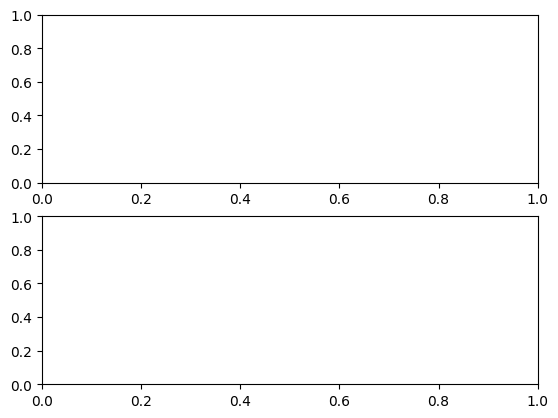

In [20]:
fig, axs = plt.subplots(2, 1)
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].axvline(
        x=iteration_when_stop_training_predators,
        label="Agent (evader) stop training",
        color="orange",
    )
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
plt.show()

## Video
Creates and saves a video replay

In [ ]:

# Replace tmpdir with any desired path where the video should be saved

with tempfile.TemporaryDirectory() as tmpdir:
    print(f"tmp: {tmpdir}")
    tmpdir = "/home/lilly/dev/marl-predator-prey/marl-predator-prey/videos"
    video_logger = CSVLogger("vmas_logs", tmpdir, video_format="mp4")
    print("Creating rendering env")
    env_with_render = TransformedEnv(env.base_env, env.transform.clone())
    env_with_render = env_with_render.append_transform(
        PixelRenderTransform(
            out_keys=["pixels"],
            # the np.ndarray has a negative stride and needs to be copied before being cast to a tensor
            preproc=lambda x: x.copy(),
            as_non_tensor=True,
            # asking for array rather than on-screen rendering
            mode="rgb_array",
        )
    )
    env_with_render = env_with_render.append_transform(
        VideoRecorder(logger=video_logger, tag="vmas_rendered")
    )
    with set_exploration_type(ExplorationType.DETERMINISTIC):
        print("Rendering rollout...")
        env_with_render.rollout(100, policy=agents_exploration_policy)
    print("Saving the video...")
    env_with_render.transform.dump()
    print("Saved! Saved directory tree:")
    video_logger.print_log_dir()


# CLEANUP

In [ ]:

# Remove scratch dir
try:
    import shutil

    for scratch_dir in scratch_dirs:
        # Use shutil.rmtree() to delete the directory and all its contents
        shutil.rmtree(scratch_dir)
        print(f"Directory '{scratch_dir}' deleted successfully.")
except FileNotFoundError:
    print(f"Directory '{scratch_dir}' not found.")
except Exception as e:
    print(f"Error deleting directory: {e}")
# sphinx_gallery_end_ignore